# Final Project Step 3 - Conduct Statistical Analysis

## Grace Brewer and Isaac Huntington

Dataset: https://github.com/gcbrewe/BIOS584_FinalProject_GraceBrewer_IsaacHuntington

Design: Cross-sectional / one outcome per study

We would like to better understand the association of speech outcomes in children with nonsyndromic cleft palate with or without cleft lip. Our dataset includes results from various studies on speech and clefting. The research questions we aim to answer are:
1. How do the different studies differ in their reported effect sizes for the same association of clefting and speech?
2. What is the association between the type of cleft and speech performance scores?
3. Does age of cleft repair have an association with speech performance?
4. Is there an association between cleft type and location in the studies?

## Data: 
- Each row corresponds to one study. 

Variables used
* `study_id` : unique study identifier
* `age` : mean age for the cleft group (numeric, in months)
* `pal_repair_age` : reported mean age of palate repair (numeric, in months)
* `cleft_type` : integer code (1,2,3,4,5) 1 = cleft palate only; 2 = cleft lip only; 3 = unilateral cleft palate and lip; 4 = bilateral cleft palate and lip; 5 = mixed sample
* `location` : categorical ('USA', 'other') 1 = other; 0 = USA
* `cleft_n`, `cleft_mean`, `cleft_sd` : sample size, mean, and SD for the cleft group
* `compare_n`, `compare_mean`, `compare_sd` : same for comparison/control group
* `eff_size` : hedge's g value of effect size

## Analysis Steps:
1. Import data into Python with Pandas. 
2. Conduct QC to address missing values, select relevant data, and make sure everything is in the correct format.
    a. Filter for construct = 1 for speech studies.
        b. Filter for subconstructs = 12 or 13.
3. Look at summary statistics of the data.
4. Follow statistical analysis plan (below) for analysis. 

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import scipy.stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [2]:
plt.rcParams['figure.dpi'] = 120

In [3]:
DATA_PATH = '{}/Lancaster_etal_JSLHR_SuppE_studydata.csv'.format(os.getcwd())

In [4]:
#Hedges' g from case / control summary statistics
def hedges_g_from_means(m1, sd1, n1, m2, sd2, n2):
    s_p = np.sqrt(((n1-1)*sd1**2 + (n2-1)*sd2**2) / (n1 + n2 - 2))
    if s_p == 0 or np.isnan(s_p):
        return np.nan, np.nan
    d = (m1 - m2) / s_p
    df = n1 + n2 - 2
    J = 1 - (3 / (4*df - 1)) if df > 2 else 1.0
    g = d * J
    var_d = (n1 + n2) / (n1 * n2) + (d**2) / (2*(n1 + n2))
    var_g = var_d * J**2
    return g, var_g

### DerSimonian-Laird random effects
* random-effects model for a meta-analytic approach that includes study-to-study variability beyond what would be expected by chance

In [5]:
def dersimonian_laird(y, v):
    mask = ~np.isnan(y) & ~np.isnan(v)
    y = np.array(y)[mask]
    v = np.array(v)[mask]
    k = len(y)
    if k == 0:
        return None
    w = 1.0 / v
    fixed_mean = np.sum(w * y) / np.sum(w)
    Q = np.sum(w * (y - fixed_mean)**2)
    df = max(0, k - 1)
    c = np.sum(w) - np.sum(w**2) / np.sum(w)
    tau2 = max(0, (Q - df) / c) if c > 0 else 0.0
    W_star = 1.0 / (v + tau2)
    pooled = np.sum(W_star * y) / np.sum(W_star)
    se = np.sqrt(1.0 / np.sum(W_star))
    ci_low = pooled - 1.96 * se
    ci_high = pooled + 1.96 * se
    return {'pooled': pooled, 'se': se, 'ci': (ci_low, ci_high), 'tau2': tau2, 'Q': Q, 'df': df, 'k': k, 'weights': W_star, 'mask': mask}

## 1) Load data

In [6]:
if os.path.exists(DATA_PATH):
    df = pd.read_csv(DATA_PATH)
    print(f"Loaded data from {DATA_PATH}. Rows: {len(df)}")
else:
    print(f"{DATA_PATH} not found.")

Loaded data from /Users/gracebrewer/Documents/GitHub/BIOS584_FinalProject_GraceBrewer_IsaacHuntington/Lancaster_etal_JSLHR_SuppE_studydata.csv. Rows: 241


In [7]:
print('Shape:', df.shape)
print(df.head())

Shape: (241, 27)
   effect_id  study_id  study_design  construct  sub_construct measure_type  \
0       1296         2             5          2             22            1   
1       1365         2             5          2             21            1   
2       1874         2             5          2             22            2   
3         35         3             2          1             12            .   
4        317         3             2          1             12            .   

  sample_context                                   name    age  cleft_type  \
0              0                MCDI - Expressive (raw)   30.0           5   
1              0  MCDI - Comprehension/Conceptual (raw)   30.0           5   
2              0                                    MLU   30.0           5   
3              1                 Screening Test of TDTA  104.0           3   
4              1                                   IPAT  104.0           3   

   ...     var test_fam test_analy  tes

In [8]:
column_names_index = df.columns
print(column_names_index)

Index(['effect_id', 'study_id', 'study_design', 'construct', 'sub_construct',
       'measure_type', 'sample_context', 'name', 'age', 'cleft_type',
       'cleft_n', 'cleft_mean', 'cleft_sd', 'compare_n', 'compare_mean',
       'compare_sd', 'eff_size', 'var', 'test_fam', 'test_analy',
       'test_statistic', 'test_alpha', 'num_var', 'location', 'year',
       'pal_repair_age', 'pal_repair_type'],
      dtype='object')


## 2) QC & summary statistics

In [9]:
#Construct = 1 for speech studies
df['construct'] = 1
numeric_cols = ['age','cleft_type','cleft_n','cleft_mean','cleft_sd','compare_n','compare_mean','compare_sd']
for c in numeric_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')

#Drop missing stats
essential = [c for c in ['cleft_n','cleft_mean','cleft_sd','compare_n','compare_mean','compare_sd', 'eff_size'] if c in df.columns]
df = df.dropna(subset=essential).reset_index(drop=True)

print('Rows after QC =', len(df))
print(df[numeric_cols].describe().T)

Rows after QC = 232
              count       mean        std   min    25%    50%      75%    max
age           232.0  46.752802  21.981300  12.0  24.50  54.20  58.8000  104.0
cleft_type    232.0   4.275862   1.181284   1.0   3.00   5.00   5.0000    5.0
cleft_n       232.0  20.780172  15.760352   5.0  12.00  15.00  26.0000   92.0
cleft_mean    232.0  31.244310  46.495764  -3.3   3.00  13.30  37.7000  348.4
cleft_sd      232.0  14.188922  27.664075   0.0   2.70   7.70  17.8250  260.0
compare_n     232.0  24.620690  18.040673   5.0  12.75  20.00  29.0000  165.0
compare_mean  232.0  38.586466  69.038444  -1.1   2.00  10.75  57.6275  547.3
compare_sd    232.0  11.967112  35.336171   0.0   1.90   3.70   9.8000  350.0


## 3) Compute study effect sizes (Hedges' g)

In [10]:
#Hedges' g and its variance for each study
g_list = []
v_list = []
for idx, row in df.iterrows():
    g, v = hedges_g_from_means(row['cleft_mean'], row['cleft_sd'], int(row['cleft_n']),
                               row['compare_mean'], row['compare_sd'], int(row['compare_n']))
    g_list.append(g)
    v_list.append(v)

df['hedges_g'] = g_list
df['var_g'] = v_list

df[['study_id','cleft_type','age','hedges_g','var_g']].head()

,study_id,cleft_type,age,hedges_g,var_g
0,2,5,30.0,-0.698884,0.072572
1,2,5,30.0,-0.697422,0.072554
2,2,5,30.0,-0.326553,0.069222
3,3,3,104.0,-1.199647,0.219434
4,3,3,104.0,-1.175571,0.218005


## Aim 1

To address the first aim, we intend to perform another one-way ANOVA to understand the differences in effect sizes for the different cleft and speech studies. The effect size measures how strong the relationship is between clefting and speech variables. Overall we expect similar effect size results, but some of the studies may have outlier results that would show issues with reproductibilty. We will visualize these results with a forest plot to see the mean and confidence intervals for each study.

### Random-effects meta-analysis of effect sizes (Hedges' g)

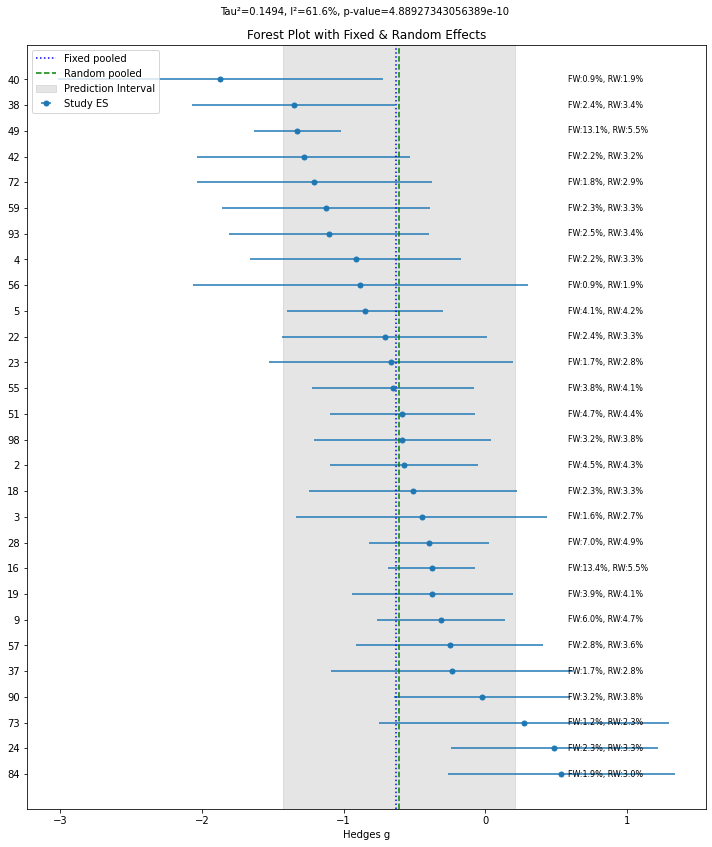

In [11]:
df_clean = df.dropna(subset=['var_g']).copy()

study_groups = df_clean.groupby('study_id').agg(
    hedges_g=('hedges_g', 'mean'),
    var_g=('var_g', 'mean')).reset_index()

y = study_groups['hedges_g'].values
v = study_groups['var_g'].values
labels = study_groups['study_id'].values
k = len(y)

#Random-effects meta-analysis
res = dersimonian_laird(y, v)
if res is None:
    raise ValueError('No valid effect sizes available')

tau2 = res['tau2']
Q = res['Q']
df_Q = k - 1
I2 = max(0, (Q - df_Q) / Q) * 100
pooled = res['pooled']
se_pooled = res['se']
z = pooled / se_pooled
p_value = 2 * (1 - scipy.stats.norm.cdf(abs(z)))

epsilon = 1e-6
v_safe = np.where(v == 0, epsilon, v)

fixed_wt = 1 / v_safe
fixed_wt_pct = 100 * fixed_wt / fixed_wt.sum()

random_wt = 1 / (v_safe + tau2)
random_wt_pct = 100 * random_wt / random_wt.sum()

M = np.sum(random_wt * y) / np.sum(random_wt)
VMR = 1 / np.sum(random_wt)
tval = scipy.stats.t.ppf(0.975, df_Q)
upper_PI = M + tval * np.sqrt(tau2 + VMR)
lower_PI = M - tval * np.sqrt(tau2 + VMR)

fixed_pooled = np.sum(fixed_wt * y) / np.sum(fixed_wt)

order = np.argsort(y)
y_sorted = y[order]
se_sorted = np.sqrt(v_safe[order])
labels_sorted = labels[order]
fixed_wt_sorted = fixed_wt_pct[order]
random_wt_sorted = random_wt_pct[order]
yi = np.arange(k)

plt.figure(figsize=(10, k*0.35 + 2))
plt.errorbar(y_sorted, yi, xerr=1.96*se_sorted, fmt='o', markersize=5, label='Study ES')
plt.axvline(fixed_pooled, color='blue', linestyle=':', label='Fixed pooled')
plt.axvline(M, color='green', linestyle='--', label='Random pooled')
plt.axvspan(lower_PI, upper_PI, color='gray', alpha=0.2, label='Prediction Interval')

plt.yticks(yi, labels_sorted)
plt.gca().invert_yaxis()
plt.xlabel("Hedges g")
plt.title("Forest Plot with Fixed & Random Effects")

for i, (fx, rd) in enumerate(zip(fixed_wt_sorted, random_wt_sorted)):
    plt.text(max(y_sorted)+0.05, i, f'FW:{fx:.1f}%, RW:{rd:.1f}%', va='center', fontsize=8)

stats_text = f'Tau²={tau2:.4f}, I²={I2:.1f}%, p-value={p_value}'
plt.text(min(y_sorted)-0.001, -2.5, stats_text, fontsize=10)

plt.legend()
plt.tight_layout()
plt.show()

### Funnel plot of publication bias

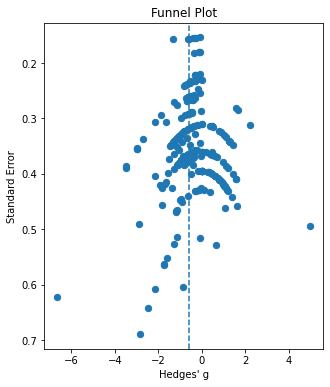

In [12]:
plt.figure(figsize=(5, 6))
plt.scatter(df['hedges_g'], np.sqrt(df['var_g']), s=40)
plt.axvline(res['pooled'], linestyle='--')
plt.gca().invert_yaxis()
plt.xlabel("Hedges' g")
plt.ylabel("Standard Error")
plt.title("Funnel Plot")
plt.show()

### One-way ANOVA of effect sizes by cleft_type

ANOVA hedges_g ~ cleft_type: F = 0.8504, p = 0.4677


<Figure size 432x288 with 0 Axes>

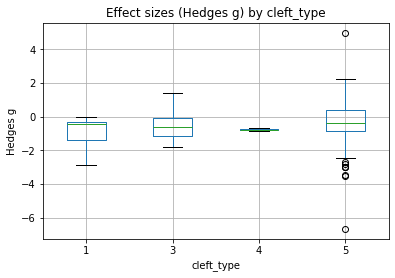

In [13]:
groups_g = [group['hedges_g'].values for name, group in df.groupby('cleft_type') if len(group)>0]
if len(groups_g) >= 2:
    anova_g = stats.f_oneway(*groups_g, nan_policy='omit')
    print('ANOVA hedges_g ~ cleft_type: F = {:.4f}, p = {:.4g}'.format(anova_g.statistic, anova_g.pvalue))
else:
    print('Not enough groups')

plt.figure(figsize=(6,4))
df.boxplot(column='hedges_g', by='cleft_type')
plt.title('Effect sizes (Hedges g) by cleft_type')
plt.suptitle('')
plt.xlabel('cleft_type')
plt.ylabel('Hedges g')
plt.show()

## Aim 2

To address the second aim, we intend to perform a one-way ANOVA to determine if there is an association between the type of cleft and speech performance scores. Cleft types 1, 2, 3, 4, 5 correspond to cleft palate only, cleft lip only, unilateral cleft palate and lip, ilateral cleft palate and lip, and mixed sample respectively.  This test would allow us to determine if there is a difference between the means of the different cleft groups. We would visualize the results using a box plot to show the distribution of each group.

### One-way ANOVA of cleft type vs speech mean (study-level)

One-way ANOVA (cleft_mean ~ cleft_type): F = 7.3577, p = 9.965e-05


<Figure size 432x288 with 0 Axes>

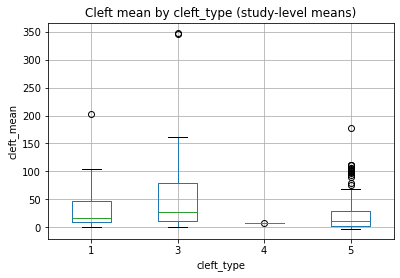

In [14]:
#One-way ANOVA for study-level cleft_mean across cleft_type
groups = [group['cleft_mean'].values for name, group in df.groupby('cleft_type') if len(group)>0]
if len(groups) >= 2:
    anova_res = stats.f_oneway(*groups)
    print('One-way ANOVA (cleft_mean ~ cleft_type): F = {:.4f}, p = {:.4g}'.format(anova_res.statistic, anova_res.pvalue))
else:
    print('Not enough groups for ANOVA')

#Boxplot
plt.figure(figsize=(6,4))
df.boxplot(column='cleft_mean', by='cleft_type')
plt.title('Cleft mean by cleft_type (study-level means)')
plt.suptitle('')
plt.xlabel('cleft_type')
plt.ylabel('cleft_mean')
plt.show()

## Aim 3

To address the third aim, we intend to conduct a random effects meta regression of age of repair and mean difference of effect size, the hedges g value, between the control mean, standard deviation, and variance and sample mean, sample standard deviation, and sample variance to see if there is a difference in speech scores between different ages of subjects. The summary statistics will include mean, SD, and variance across different effect groups and effect sizes. We will visualize these results using forest plots, bubble plots, and tornado charts.

### Meta-regression: age as covariate

                            WLS Regression Results                            
Dep. Variable:               hedges_g   R-squared:                       0.174
Model:                            WLS   Adj. R-squared:                  0.169
Method:                 Least Squares   F-statistic:                     34.03
Date:                Fri, 05 Dec 2025   Prob (F-statistic):           2.89e-08
Time:                        15:34:13   Log-Likelihood:                -236.98
No. Observations:                 163   AIC:                             478.0
Df Residuals:                     161   BIC:                             484.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.4927      0.211     -7.082      0.0

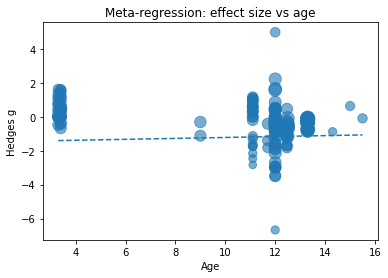

In [15]:
df['pal_repair_age'] = pd.to_numeric(df['pal_repair_age'], errors='coerce')
df_meta = df.dropna(subset=['hedges_g','pal_repair_age','var_g']).copy()
tau2 = res['tau2']
df_meta['w'] = 1.0 / (df_meta['var_g'] + tau2)
if res is None:
    print('No meta-analysis result (skipping meta-regression)')
else:
    tau2 = res['tau2']
    df_meta = df.dropna(subset=['hedges_g','pal_repair_age','var_g']).copy()
    df_meta['w'] = 1.0 / (df_meta['var_g'] + tau2)
    X = sm.add_constant(df_meta['age'])
    mr = sm.WLS(df_meta['hedges_g'], X, weights=df_meta['w']).fit()
    print(mr.summary())

    #Bubble plot: effect size vs age (bubble size ~ weight)
    plt.figure(figsize=(6,4))
    sizes = (df_meta['w'] / df_meta['w'].max()) * 200
    plt.scatter(df_meta['pal_repair_age'], df_meta['hedges_g'], s=sizes, alpha=0.6)
    xs = np.linspace(df_meta['pal_repair_age'].min(), df_meta['pal_repair_age'].max(), 100)
    ys = mr.params['const'] + mr.params['age'] * xs
    plt.plot(xs, ys, linestyle='--')
    plt.xlabel('Age')
    plt.ylabel('Hedges g')
    plt.title('Meta-regression: effect size vs age')
    plt.show()

## Aim 4

To address the fourth aim, we intend to do a Chi-squared test to understand the association between cleft type and location of subjects. We would like to understand if being born in the US has any relationship to having a cleft. We will visulaize  these results by using a bar plot to see the observed versus the expected results.

### Chi-squared test for association between cleft_type and location

Contingency table:
 location     0   1
cleft_type        
1           10   4
3           23  31
4            0   4
5           72  88
Chi-square test: chi2 = 7.3364, p = 0.06192, dof = 3


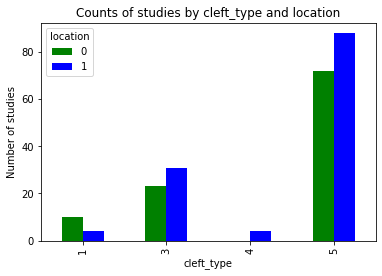

In [16]:
if 'location' in df.columns:
    ct = pd.crosstab(df['cleft_type'], df['location'])
    print('Contingency table:\n', ct)
    chi2, p, dof, ex = stats.chi2_contingency(ct)
    print('Chi-square test: chi2 = {:.4f}, p = {:.4g}, dof = {}'.format(chi2, p, dof))
else:
    print("'location' column not found")

#Bar plot of counts
ct.plot(kind='bar', color=["green", "blue"])
plt.title('Counts of studies by cleft_type and location')
plt.xlabel('cleft_type')
plt.ylabel('Number of studies')
plt.show()

## Logistic regression and odds ratio

In [17]:
df['location'] = df['location'].astype(int)

df['cleft_type_code'] = df['cleft_type'].astype('category').cat.codes

#Dependent variable
y = df['cleft_type_code'].values

#Predictor (location)
X = sm.add_constant(df['location'].values)

#Multinomial logistic regression
model = sm.MNLogit(y, X)
result = model.fit()
print(result.summary())

#Odds ratios
odds_ratios = np.exp(result.params)
print('\nOdds Ratios:')
print(odds_ratios)

         Current function value: 0.815801
         Iterations: 35
                          MNLogit Regression Results                          
Dep. Variable:                      y   No. Observations:                  232
Model:                        MNLogit   Df Residuals:                      226
Method:                           MLE   Df Model:                            3
Date:                Fri, 05 Dec 2025   Pseudo R-squ.:                 0.02298
Time:                        15:34:13   Log-Likelihood:                -189.27
converged:                      False   LL-Null:                       -193.72
Covariance Type:            nonrobust   LLR p-value:                   0.03059
       y=1       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8329      0.379      2.199      0.028       0.091       1.575
x1             1.2148      0.652      1.862      0.063      -0.06

/Users/gracebrewer/Documents/GitHub/BIOS584_FinalProject_GraceBrewer_IsaacHuntington/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


#### All analyses will be performed in Python using these packages: pandas,  numpy, matplotlib, scipy.stats, pymare, statsmodels, and pythonmeta, and forestplot.
